In [1]:
#imports to be used later on
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap
from astropy.io import fits
import matplotlib
import scipy.ndimage
import scipy.interpolate
from astropy.table import Table
import astropy.units as u
%matplotlib inline

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import gala.integrate as gi
from gala.units import galactic, UnitSystem

import astropy.coordinates as coord
from astropy.coordinates import SkyOffsetFrame 
from astropy.wcs import WCS
plt.ioff

import reproject

In [2]:
path = '/Users/spearson/Desktop/Research/CenA/'
plot_path = '/Users/spearson/Desktop/Research/CenA/CenA2021/plots/'

In [3]:
mpl.rcParams.update({'font.size': 24})
label_size = 24
mpl.rcParams['xtick.labelsize'] = 18#label_size 
mpl.rcParams['ytick.labelsize'] =18 #label_size 

# Data

In [4]:
# control points in ICRS
centroids = np.genfromtxt(path+'CenA2021/centroids.txt')


# maybe later have widths
widths_up = np.genfromtxt(path+'CenA2021/widths_up.txt')
widths_down = np.genfromtxt(path+'CenA2021/widths_down.txt')
c_widths_up =  coord.SkyCoord(widths_up[0,:]*u.deg, \
                             widths_up[1,:]*u.deg)

c_widths_down =  coord.SkyCoord(widths_down[0,:]*u.deg, \
                             widths_down[1,:]*u.deg)

# Skyoffset frame
To make control data points horizontal

In [5]:
def cenA_skyoffset(center_coords , angle):
    """To use this function use data.transform_to(cenA_skyoffset(c_CenA,alpha))"""
    
    offset = SkyOffsetFrame(origin=center_coords, rotation=alpha)
    return offset

# Simulate stream

In [6]:
def generate_stream(prog_pos, vel, dw3_mass, dw3_b, halo_mass, halo_c,t_integrate):

    """Simulate stream and orbit of progenitor"""
    #should step over these parameters below....
    w0 = gd.PhaseSpacePosition(prog_pos.cartesian.xyz.to(u.kpc),
                            vel )
    pot = gp.NFWPotential.from_M200_c(halo_mass, c=halo_c, units=galactic)
   
    df = gd.mockstream.FardalStreamDF()
    gen = gd.MockStreamGenerator(df, gp.Hamiltonian(pot), 
                             progenitor_potential=gp.PlummerPotential(m=dw3_mass, 
                                                                      b=dw3_b, 
                                                                      units=galactic))
    stream_dw3, _ = gen.run(w0, prog_mass=dw3_mass, release_every=3, 
                    dt=-1*u.Myr, n_steps=t_integrate)
    orbit = gp.Hamiltonian(pot).integrate_orbit(w0, dt=-1., n_steps=t_integrate)
    
    return stream_dw3, orbit

# Interpolater

In [7]:
step_size = 0.01 #deg

def control_interpolate(xlon, ylat , steps):
    f = scipy.interpolate.interp1d(x= xlon, y = ylat)
    lon_new = np.arange(np.min(xlon), (np.max(xlon)), steps)
    lat_new = f(lon_new)
    return lon_new,lat_new

# Final plot

In [43]:
def plot_streamfit_orbit(sim_stream_lon_inter,sim_stream_lat_inter,\
                        stream_lon, stream_lat,sim_lon_n,sim_lat_n,\
                        c_control_offset_lon, c_control_offset_lat,sigma_n,lnL, orbit, stream):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    ax1.plot(sim_stream_lon_inter ,sim_stream_lat_inter, label='interpolated simulated stream track')


    ax1.scatter(stream_lon, stream_lat,
            alpha=0.4, s=4, color='lightblue', label='simulated stream stars')


    ax1.scatter(sim_lon_n,sim_lat_n,
            alpha=1, s=10, color='black', label='n simulation evaluation points')


    ax1.errorbar(c_control_offset_lon.deg, c_control_offset_lat.deg,yerr=sigma_n, xerr=None, \
             fmt='.', ecolor='red', color='red',elinewidth=1,markersize=2,label='n data points')#,transform=ax.get_transform('icrs'))

    ax1.text(0.3,1.4,'ln$L$ = ' + str(np.round(lnL,2)), color ='red', size=18)

    ax1.legend( fontsize=16, loc='best')
    ax1.set_xlim([-2,2])
    ax1.set_ylim([-2,2])
    ax1.set_xlabel('xlon [deg]')
    ax1.set_ylabel('ylat [deg]')
    
    pos_in_time = np.sqrt(orbit.pos.x**2+orbit.pos.y**2+orbit.pos.z**2)
    ax2.plot(orbit.t,pos_in_time, label='orbit')
    ax2.set_xlabel('time [Myr]')
    ax2.set_ylabel('$R_{GC}$ [kpc]')
    fig.tight_layout()
    
    #save plot with info of vel and lnL
    fig.savefig(plot_path+'stream_'+ str(np.round(np.sqrt(stream.vel.d_x**2 +\
                                                 stream.vel.d_y**2 + \
                                                 stream.vel.d_z**2).to(u.km/u.second)[0],1).value)+\
            '_km_s_lnL_'+str(np.round(lnL,2))+'.png')

# Call lnL function

In [53]:
def call_lnL(data , angle, \
             distance,dw_distance ,\
             vel , mass, \
            b , halo_mass , \
             halo_c, t_integrate):
    """
    Function that calculates the lnL of a stream simulation to input control
    data from the Dw3 stream in Cen A
    
    1. Transforms ICRS data from dw3 stream to skyoffset frame
    2. Generates Dw3 stream and orbit in CenA GC frame
    3. Transforms stream to skyoffset frame centerd on cenA rotated to horizontal stream
    4. Fits ridgeline through stream simulation in skyoffset frame
    5. Evaluates lnL of generated stream compared to control data points
    """
    #need to define here for class below
    CenA_distance = distance
    dw3_distance = dw_distance
    alpha = angle
    
    #First use distance to define skycoords of Cen A in ICRS
    #Cen A skypos
    c_CenA = coord.SkyCoord(ra = 201.365063*u.deg, dec =-43.019113*u.deg,\
                        distance=CenA_distance )

    # Ans also the Dw3 in ICRS
    # dwarf pos
    pos = coord.SkyCoord(ra=202.607*u.deg, dec=-42.2*u.deg,\
                        distance=dw3_distance)
    
    # First rotate data points to skyoffset frame
    c_centroids =  coord.SkyCoord(centroids[0,:]*u.deg, \
                             centroids[1,:]*u.deg)
    
    c_control_offset_lon = c_centroids.transform_to\
                        (cenA_skyoffset(c_CenA,angle)).lon
    c_control_offset_lat =  c_centroids.transform_to\
                        (cenA_skyoffset(c_CenA,angle)).lat

   
    # Define CenA frame
    # Frame to simulate stream in
    # Milky Way is along the z-axis x and y axes are 
    # oriented with the Cen A stream from Dwarf III
    # First need galactocentric frame to simulate stream in
    class CenAGalactocentric(coord.BaseCoordinateFrame):
        """
        Position at the center of Cen A
    
        Milky Way is along the z-axis
        x and y axes are oriented with the Cen A stream from Dwarf III
        """

        default_representation = coord.CartesianRepresentation
        default_differential = coord.CartesianDifferential

        # Frame attributes
        CenA_sky_coord = coord.CoordinateAttribute(
            frame=coord.ICRS,
            default=coord.SkyCoord(c_CenA.ra.deg, c_CenA.dec.deg, unit=u.deg)
        )
    
        CenA_distance = coord.QuantityAttribute(
            default=CenA_distance,# * u.Mpc,
            unit=u.Mpc
        )

        alpha = coord.QuantityAttribute(
            default=alpha,
            unit=u.deg
        )

    #Don't fully understand if I need the below for the angle, I already do this in the skyoffset frame
    from astropy.coordinates.matrix_utilities import rotation_matrix

    def get_icrs_to_cena_transform(cena_frame, icrs_frame, inverse=False):
        """
        Get the transformation matrix to go from ICRS to Cen A coordinates.
    
        Note: Currently this only does positions correctly
        """
    
        # Rotation matrix to go from CenA to ICRS
        Rz = rotation_matrix(-cena_frame.CenA_sky_coord.ra, 'z')
        Ry = rotation_matrix(cena_frame.CenA_sky_coord.dec, 'y')
        Rx = rotation_matrix(cena_frame.alpha, 'x')
        R = Rz @ Ry @ Rx
    
        # Positional offset to the center of Cen A (from ICRS)
        dpos = coord.CartesianRepresentation(cena_frame.CenA_distance * [1., 0, 0])

        if inverse:  # Cen A to ICRS
            A = R
            b = (dpos).transform(A)

        else:  # ICRS to Cen A
            A = R.T
            b = -dpos

        return A, b


    @coord.frame_transform_graph.transform(
        coord.transformations.AffineTransform,
        coord.ICRS,
        CenAGalactocentric
    )
    def icrs_to_cena(icrs_coord, cena_frame):
        return get_icrs_to_cena_transform(cena_frame, icrs_coord)


    @coord.frame_transform_graph.transform(
        coord.transformations.AffineTransform,
        CenAGalactocentric,
        coord.ICRS
    )
    def cena_to_icrs(cena_coord, icrs_frame):
        return get_icrs_to_cena_transform(cena_coord, icrs_frame, inverse=True)
    
    
    # Use CenA Galactocentric frame to get stream progentor pos
    dw3_pos_GC = pos.transform_to(CenAGalactocentric())
    #print('dw3 present day pos: ' + str(dw3_pos_GC))
    
    # Generate stream and orbit of progentiro
    stream, orbit = generate_stream(prog_pos = dw3_pos_GC, vel=vel, dw3_mass=mass, \
                                    dw3_b=b, halo_mass=halo_mass,\
                                    halo_c=halo_c,t_integrate=t_integrate)
    
    
    #Transform the stream from Galactic frame to CenA centered and rotated frame
    cena_stream = CenAGalactocentric(stream.pos.with_differentials(stream.vel))
    cena_stream_icrs = cena_stream.transform_to(coord.ICRS())

    stream_lon = cena_stream_icrs.transform_to(cenA_skyoffset(center_coords = \
                                                              c_CenA, angle = angle)).lon
    stream_lat = cena_stream_icrs.transform_to(cenA_skyoffset(center_coords = \
                                                              c_CenA, angle = angle)).lat
   

    # Fit ridgeline through stream for stream to data comparison
    # bin size
    d_xlon = 0.15 #deg

    xlon = np.arange(np.min(stream_lon.deg), np.max(stream_lon.deg), d_xlon)
    #center, bc = bin center
    xlon_bc = 0.5*(xlon[1:] + xlon[:-1])

    #number of bins 
    Nb = np.size(xlon_bc) 
    ylat_med = np.zeros(Nb)#*u.deg
    #print(Nb)

    for i in range(Nb):
        ind = (stream_lon.value>xlon[i]) & (stream_lon.value<=xlon[i+1])# & tout['grz_mask'] & concave_mask
        ylat_med[i] = np.median(stream_lat.value[ind])
    
    # Interpolate so I have stream track at each xlon value
    
    sim_stream_lon_inter ,sim_stream_lat_inter =\
                                    control_interpolate(xlon = xlon_bc, ylat = ylat_med,\
                                    steps = step_size )
    
    # Now only grab the interpolated stream track at the xlon values of the input data
    idx = np.zeros(len(sim_stream_lon_inter), dtype=bool)
    #for all interpolated stream star track values, grab data ones
    for i in range(len(sim_stream_lon_inter)): 
        #number of data points
        for j in range(len(c_control_offset_lon.deg)): 
            if np.abs(sim_stream_lon_inter[i] - c_control_offset_lon[j].deg)<step_size/2:
                #these indices are the ones to grab for stream track
                idx[i] = True 
       
    #new points for the simulated stream track at same value as data
    sim_lon_n = sim_stream_lon_inter[idx] 
    sim_lat_n = sim_stream_lat_inter[idx]
    
    # Now compute lnL function
    # We look at difference between simulated stream track and the input data and its 
    # vertical errors
    Delta_n = np.abs(c_control_offset_lat.deg - sim_lat_n)
    #the sigma_n is the error in the vertical direction
    # for now they are just all 0.01 deg
    sigma_n = np.ones(len( c_control_offset_lat.deg))*0.01

    Chi_2 = np.sum(Delta_n**2/sigma_n**2 )
    lnL = -0.5 * (Chi_2)
    print('lnL = ' + str(np.round(lnL,2)))
    
    #Produce final output plot
    plot_streamfit_orbit(sim_stream_lon_inter,sim_stream_lat_inter,\
                        stream_lon, stream_lat,sim_lon_n,sim_lat_n,\
                        c_control_offset_lon, c_control_offset_lat,sigma_n,lnL, orbit, stream)
    
    return "plot saved in: " + str(plot_path)

# Free input parameters.
Can change when we call "lnL function"

In [60]:
# distance to CenA
CenA_distance = 3.8*u.Mpc# 3.8*u.Mpc
dw3_distance = 3.88* u.Mpc# #If I set to 1.8Mpc, there's a problem in xlon interpolation
#problem: right now coordinate frame shifts with CenA distance

#rotation to horizontal stream
alpha = 50*u.deg

#dwarf properties
dw3_mass = 1e7*u.Msun
dw3_b = 0.5 *u.kpc
dw3_vel = [0, 300, 0]* u.km/u.s
nsteps = 4000 #Myr

#halo properties
m_halo = 2.e12*u.Msun
c_halo= 15

# Run


dw3 present day pos: <SkyCoord (CenAGalactocentric: CenA_sky_coord=<ICRS Coordinate: (ra, dec) in deg
    (201.365063, -43.019113)>, CenA_distance=3.8 Mpc, alpha=50.0 deg): (x, y, z) in Mpc
    (0.07910984, -0.00209287, 0.08308118)>
lnL = -226.76


'plot saved in: /Users/spearson/Desktop/Research/CenA/CenA2021/plots/'

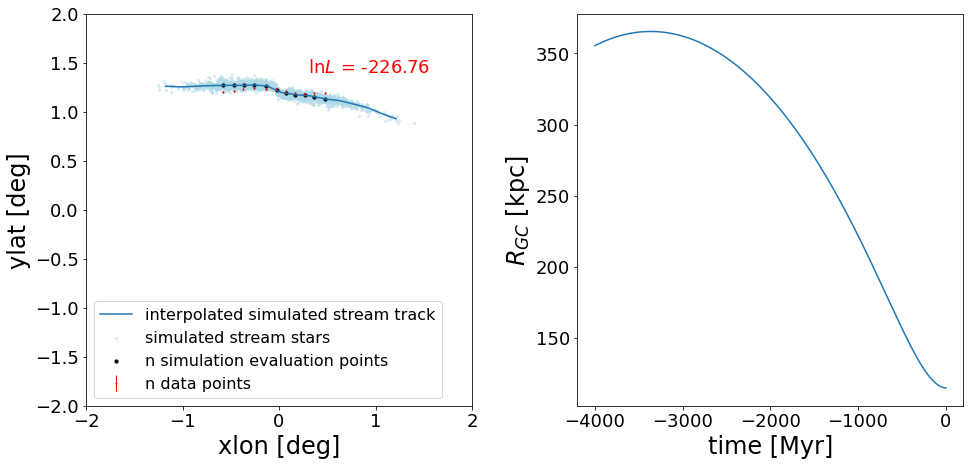

In [61]:
call_lnL(data = centroids, angle = alpha, distance = CenA_distance,dw_distance= dw3_distance, \
                          vel = dw3_vel, mass=dw3_mass,   \
                         b = dw3_b, halo_mass = m_halo, halo_c= c_halo,\
                         t_integrate=nsteps)



In [ ]:
#_ = stream.plot(alpha=0.25, s=4, color='lightblue')

In [ ]:
#fig = orbit.plot()